In [1]:
import pandas as pd
import numpy as np
import os

# Dataset Overview

In [2]:
# Define paths
TRAIN_AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train"
TEST_AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test"

# Get list of .wav files
train_files = [f for f in os.listdir(TRAIN_AUDIO_DIR) if f.endswith(".wav")]
test_files = [f for f in os.listdir(TEST_AUDIO_DIR) if f.endswith(".wav")]

# Display counts
print(f"Number of training audio files: {len(train_files)}")
print(f"Number of testing audio files: {len(test_files)}")

Number of training audio files: 444
Number of testing audio files: 204


*Also we have already been given information regarding duration of each .wav, it's about 45-60 seconds.*

So we have around 444 training audio files and 204 testing audio files, we have information regarding audio file length rannging from 45-60 seconds.

To perform a sort of grammar scoring on these audio files, we would first need to convert these wav's to text, we will use an open source speech to text model for that named *whisper*

# Performing ASR (Automatic Speech Recognition)

In [3]:
!pip install -q openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 13.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

In [ ]:
import whisper

# 1. Load Whisper model
model = whisper.load_model("base")  # you can swap "base" for "small", "medium", etc.

# 2. Transcription function
def transcribe_folder(audio_folder: str, output_csv: str):
    records = []
    for fname in sorted(os.listdir(audio_folder)):
        if not fname.lower().endswith(".wav"):
            continue
        path = os.path.join(audio_folder, fname)
        print(f"Transcribing {fname} ...")
        result = model.transcribe(path)
        text = result["text"].strip()
        records.append({"file_name": fname, "transcript": text})
        
    df = pd.DataFrame(records)
    df.to_csv(output_csv, index=False)
    print(f"Saved transcripts to {output_csv}\n")
    return df

# 3. Run for train and test
train_transcripts = transcribe_folder("/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train", "/kaggle/working/train_transcripts.csv")
test_transcripts  = transcribe_folder("/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test",  "/kaggle/working/test_transcripts.csv")


*Transcriptions are done succesfully using whisper base model, and have been uploaded as notebook input.*

# Load, Clean and structure the transcripts

In [2]:
train_tr = pd.read_csv("/kaggle/input/whisper-base-transcriptions/train_transcripts.csv")
test_tr = pd.read_csv("/kaggle/input/whisper-base-transcriptions/test_transcripts.csv")

In [3]:

# Add character length and word count
train_tr["char_len"] = train_tr["transcript"].fillna("").apply(len)
train_tr["word_count"] = train_tr["transcript"].fillna("").apply(lambda x: len(str(x).split()))

test_tr["char_len"] = test_tr["transcript"].apply(len)
test_tr["word_count"] = test_tr["transcript"].apply(lambda x: len(str(x).split()))

# Detect repetitive content (e.g., "you you you")
def is_repetitive(text, threshold=0.8):
    words = str(text).split()
    if len(words) <= 1:
        return False
    most_common = max(set(words), key=words.count)
    ratio = words.count(most_common) / len(words)
    return ratio >= threshold

train_tr["is_repetitive"] = train_tr["transcript"].fillna("").apply(is_repetitive)
test_tr["is_repetitive"] = test_tr["transcript"].apply(is_repetitive)

# Flag too short or repetitive transcripts
train_tr["is_short_or_repetitive"] = (
    (train_tr["word_count"] <= 3) |
    (train_tr["char_len"] <= 10) |
    train_tr["is_repetitive"]
)

test_tr["is_short_or_repetitive"] = (
    (test_tr["word_count"] <= 3) |
    (test_tr["char_len"] <= 10) |
    test_tr["is_repetitive"]
)

# Display bad transcripts for manual review
bad_train_transcripts = train_tr[train_tr["is_short_or_repetitive"]][["file_name", "transcript"]]
bad_test_transcripts = test_tr[test_tr["is_short_or_repetitive"]][["file_name", "transcript"]]

print("Bad train transcripts:")
print(bad_train_transcripts,"\n", len(bad_train_transcripts))

print("Bad test transcripts:")
print(bad_test_transcripts,"\n", len(bad_test_transcripts))

Bad train transcripts:
         file_name                                         transcript
119  audio_148.wav  NG NG NG NG NG NG NG NG NG NG NG NG NG NG NG N...
121  audio_151.wav                                                NaN
122  audio_154.wav  t Website Univplatz ... ... ... ... ... ... .....
212  audio_370.wav  ... ... ... ... ... ... ... ... ... ... ... .....
220  audio_387.wav  A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-...
222   audio_39.wav                 niepise nd nd nd nd nd nd nd nd nd
282  audio_558.wav  2.1 4.1 4.1 4.1 4.1 5.1 5.1 5.1 5.1 5.1 5.1 5....
286  audio_566.wav  ... ... ... ... ... ... ... ... ... ... ... .....
287  audio_567.wav  I I I I I I I I I I I I I I I I I I I I I I I ...
314  audio_655.wav                                            I He're
344  audio_713.wav                        ... ... ... ... ... ... ...
407  audio_893.wav                    ... ... ... ... ... ... ... ...
419  audio_930.wav  ouch ouch ouch ouch ouch ouch ouch ouch ouch N.

So we notice Nan value, and also some weird transcriptions in train set, we shall simply remove these as these would only act as anomalies in the model's learning

# Merge data with scores and also drop bad train transcripts.

In [6]:
# Load original metadata files
train_meta = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv")
test_meta = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv")

# Rename 'filename' → 'file_name' in both meta files
train_meta.rename(columns={"filename": "file_name"}, inplace=True)
test_meta.rename(columns={"filename": "file_name"}, inplace=True)

# Drop bad transcripts from train
clean_train_tr = train_tr[~train_tr["is_short_or_repetitive"]].copy()

# Merge transcripts with meta info
train_merged = pd.merge(clean_train_tr, train_meta, on="file_name")
test_merged = pd.merge(test_meta, test_tr, on="file_name")


print("Cleaned training samples:", len(train_merged))
print("Total test samples (untouched):", len(test_merged))

Cleaned training samples: 431
Total test samples (untouched): 204


In [7]:
train_merged

,file_name,transcript,char_len,word_count,is_repetitive,is_short_or_repetitive,label
0,audio_1002.wav,"In a backdrop of a school, you might see Vasel...",796,123,False,False,5.0
1,audio_1005.wav,"So, the playground is pretty interesting. It's...",496,93,False,False,5.0
2,audio_1007.wav,"The scene of a blade round, almost we have a l...",495,95,False,False,4.5
3,audio_1012.wav,The school playground is lively and filled wit...,451,69,False,False,4.0
4,audio_1015.wav,She is getting early again. I'm not a bad guy....,613,143,False,False,5.0
...,...,...,...,...,...,...,...
426,audio_990.wav,"Typically, there would be children laughing, t...",588,104,False,False,5.0
427,audio_993.wav,I'm going to go to the bathroom. I'm going to ...,2935,623,False,False,5.0
428,audio_994.wav,There is a playground the size of four footbal...,751,137,False,False,5.0
429,audio_996.wav,The school playground is surrounded by buildin...,858,147,False,False,5.0


In [8]:
test_merged

,file_name,transcript,char_len,word_count,is_repetitive,is_short_or_repetitive
0,audio_804.wav,my Problem is Plane Guard點會快點拒絕的彌臭剩下 because I...,303,61,False,False
1,audio_1028.wav,My favorite place is in Andhra Pradesh. It is ...,352,65,False,False
2,audio_865.wav,"Yeah, my best days in my life is recently I go...",649,129,False,False
3,audio_774.wav,"Actually, the most I use it to enjoy is like p...",695,137,False,False
4,audio_1138.wav,"I would like to become a beauty unit, among th...",447,86,False,False
...,...,...,...,...,...,...
199,audio_787.wav,My favorite hobby is betting on NBA and footba...,804,159,False,False
200,audio_1079.wav,"My favorite place to travel is to Ocean City, ...",802,160,False,False
201,audio_550.wav,This journey to Switzerland is an adventure in...,691,111,False,False
202,audio_641.wav,"Well, my goal in life is to live a happy fulfi...",568,107,False,False


In [9]:
train_merged = train_merged.drop(columns=["is_repetitive","is_short_or_repetitive"])
test_merged  =  test_merged.drop(columns=["is_repetitive","is_short_or_repetitive"])

In [10]:
train_merged

,file_name,transcript,char_len,word_count,label
0,audio_1002.wav,"In a backdrop of a school, you might see Vasel...",796,123,5.0
1,audio_1005.wav,"So, the playground is pretty interesting. It's...",496,93,5.0
2,audio_1007.wav,"The scene of a blade round, almost we have a l...",495,95,4.5
3,audio_1012.wav,The school playground is lively and filled wit...,451,69,4.0
4,audio_1015.wav,She is getting early again. I'm not a bad guy....,613,143,5.0
...,...,...,...,...,...
426,audio_990.wav,"Typically, there would be children laughing, t...",588,104,5.0
427,audio_993.wav,I'm going to go to the bathroom. I'm going to ...,2935,623,5.0
428,audio_994.wav,There is a playground the size of four footbal...,751,137,5.0
429,audio_996.wav,The school playground is surrounded by buildin...,858,147,5.0


In [11]:
test_merged

,file_name,transcript,char_len,word_count
0,audio_804.wav,my Problem is Plane Guard點會快點拒絕的彌臭剩下 because I...,303,61
1,audio_1028.wav,My favorite place is in Andhra Pradesh. It is ...,352,65
2,audio_865.wav,"Yeah, my best days in my life is recently I go...",649,129
3,audio_774.wav,"Actually, the most I use it to enjoy is like p...",695,137
4,audio_1138.wav,"I would like to become a beauty unit, among th...",447,86
...,...,...,...,...
199,audio_787.wav,My favorite hobby is betting on NBA and footba...,804,159
200,audio_1079.wav,"My favorite place to travel is to Ocean City, ...",802,160
201,audio_550.wav,This journey to Switzerland is an adventure in...,691,111
202,audio_641.wav,"Well, my goal in life is to live a happy fulfi...",568,107


# Doing some visual exploratory data analysis

Missing Values in Dataset:
file_name     0
transcript    0
char_len      0
word_count    0
label         0
dtype: int64

Statistical Summary of Numerical Features:
          char_len   word_count       label
count   431.000000   431.000000  431.000000
mean    683.754060   132.881671    3.972158
std     441.246374   105.961741    1.046218
min      22.000000     5.000000    1.000000
25%     487.000000    92.000000    3.000000
50%     623.000000   117.000000    4.000000
75%     738.000000   140.000000    5.000000
max    6193.000000  1548.000000    5.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


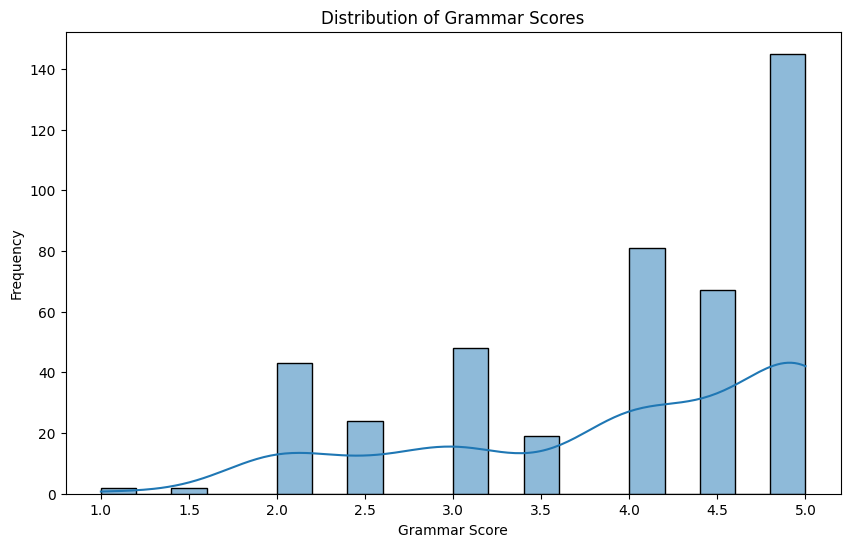

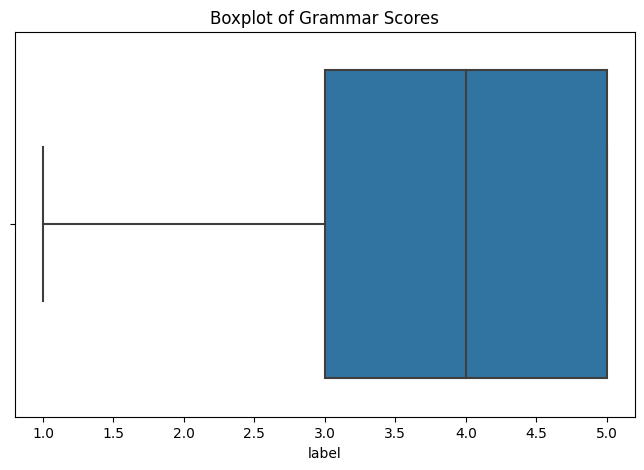

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded your 'train_merged' dataframe
df = train_merged

# 1. Check for missing values
missing_values = df.isnull().sum()
print("Missing Values in Dataset:")
print(missing_values)

# 2. Statistical summary of numerical columns
print("\nStatistical Summary of Numerical Features:")
print(df.describe())

# 3. Distribution of Grammar Scores (Histogram and KDE)
plt.figure(figsize=(10, 6))
sns.histplot(df['label'], kde=True, bins=20)
plt.title('Distribution of Grammar Scores')
plt.xlabel('Grammar Score')
plt.ylabel('Frequency')
plt.show()

# 4. Boxplot for identifying outliers in Grammar Scores
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['label'])
plt.title('Boxplot of Grammar Scores')
plt.show()


From the statistical summary and histogram and KDE plots, we can sort of visualise the distribution of our dataset, compared to their grammar scores
We can see a lot of perfect scores(5) and very little poor scores(1)

# Removing filler words and noise patterns which are common ASR outputs

In [13]:
import re

# Patterns to remove
noise_patterns = [
    r'\[.*?\]',      # [noise], [laugh], etc.
    r'\.{2,}',       # ...
]

# Common filler words
filler_words = [
    'um', 'uh', 'you know', 'like', 'i mean',
    'sort of', 'kind of', 'right', 'okay', 'ok'
]

def clean_transcript(text):
    if not isinstance(text, str):
        return ""

    # Remove noise patterns
    for pattern in noise_patterns:
        text = re.sub(pattern, ' ', text, flags=re.IGNORECASE)

    # Remove filler words
    for filler in filler_words:
        text = re.sub(rf'\b{re.escape(filler)}\b', ' ', text, flags=re.IGNORECASE)

    # Normalize whitespace and lowercase
    text = re.sub(r'\s+', ' ', text).strip().lower()

    return text

# Apply to both dataframes
train_merged['transcript_clean'] = train_merged['transcript'].apply(clean_transcript)
test_merged['transcript_clean'] = test_merged['transcript'].apply(clean_transcript)

# Quick preview
train_merged[['file_name', 'transcript_clean']].head()


,file_name,transcript_clean
0,audio_1002.wav,"in a backdrop of a school, you might see vasel..."
1,audio_1005.wav,"so, the playground is pretty interesting. it's..."
2,audio_1007.wav,"the scene of a blade round, almost we have a l..."
3,audio_1012.wav,the school playground is lively and filled wit...
4,audio_1015.wav,she is getting early again. i'm not a bad guy....


In [14]:
test_merged

,file_name,transcript,char_len,word_count,transcript_clean
0,audio_804.wav,my Problem is Plane Guard點會快點拒絕的彌臭剩下 because I...,303,61,my problem is plane guard點會快點拒絕的彌臭剩下 because i...
1,audio_1028.wav,My favorite place is in Andhra Pradesh. It is ...,352,65,my favorite place is in andhra pradesh. it is ...
2,audio_865.wav,"Yeah, my best days in my life is recently I go...",649,129,"yeah, my best days in my life is recently i go..."
3,audio_774.wav,"Actually, the most I use it to enjoy is like p...",695,137,"actually, the most i use it to enjoy is practi..."
4,audio_1138.wav,"I would like to become a beauty unit, among th...",447,86,"i would to become a beauty unit, among the art..."
...,...,...,...,...,...
199,audio_787.wav,My favorite hobby is betting on NBA and footba...,804,159,my favorite hobby is betting on nba and footba...
200,audio_1079.wav,"My favorite place to travel is to Ocean City, ...",802,160,"my favorite place to travel is to ocean city, ..."
201,audio_550.wav,This journey to Switzerland is an adventure in...,691,111,this journey to switzerland is an adventure in...
202,audio_641.wav,"Well, my goal in life is to live a happy fulfi...",568,107,"well, my goal in life is to live a happy fulfi..."


In [15]:
train = train_merged[['file_name', 'transcript_clean','label']]
test = test_merged[['file_name', 'transcript_clean']]

# Feature Extraction 

We extract features like character count, word count, sentence count, readability scores (textstat), lexical diversity, part-of-speech ratios (nltk), stopword and punctuation stats, and grammar error counts (language_tool_python) to capture writing quality and grammatical correctness.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')


In [ ]:
pip install -q textstat language-tool-python

In [ ]:
# ============================================
# Comprehensive Feature Extraction for Grammar
# ============================================

import pandas as pd
import numpy as np
import re
import nltk
import textstat
import language_tool_python
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# --------------------------------------------
# 0. Download NLTK resources (run once)
# --------------------------------------------
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

# --------------------------------------------
# 1. Initialize tools
# --------------------------------------------
tool = language_tool_python.LanguageTool('en-US', remote_server='https://api.languagetool.org')
stop_words = set(stopwords.words('english'))
punct_pattern = re.compile(r'[^\w\s]')

# --------------------------------------------
# 2. Feature extraction function
# --------------------------------------------
def extract_features(df, text_col='transcript_clean'):
    records = []
    for _, row in df.iterrows():
        text = row[text_col] or ""

        # Basic counts
        chars      = len(text)
        words      = word_tokenize(text)
        word_count = len(words)
        sentences  = sent_tokenize(text)
        sent_count = len(sentences) or 1

        # Readability
        flesch_ease  = textstat.flesch_reading_ease(text)
        flesch_grade = textstat.flesch_kincaid_grade(text)

        # Lexical
        unique_words = len(set(words))
        type_token   = unique_words / (word_count or 1)
        avg_word_len = np.mean([len(w) for w in words]) if word_count else 0
        avg_sent_len = word_count / sent_count

        # POS tagging
        tags       = nltk.pos_tag(words)
        pos_counts = {tag: sum(1 for _, t in tags if t.startswith(tag))
                      for tag in ['NN','VB','JJ','RB']}
        noun_ratio = pos_counts['NN'] / (word_count or 1)
        verb_ratio = pos_counts['VB'] / (word_count or 1)
        adj_ratio  = pos_counts['JJ'] / (word_count or 1)
        adv_ratio  = pos_counts['RB'] / (word_count or 1)

        # Stopwords & punctuation
        stop_count  = sum(1 for w in words if w.lower() in stop_words)
        stop_ratio  = stop_count / (word_count or 1)
        punct_count = len(punct_pattern.findall(text))

        # Grammar errors with exception handling
        try:
            matches = tool.check(text)
            grammar_errors = len([m for m in matches if m.ruleIssueType != 'typographical'])
        except Exception:
            grammar_errors = np.nan

        error_ratio = (grammar_errors / sent_count) if sent_count and not np.isnan(grammar_errors) else np.nan

        # Collect features
        records.append({
            'file_name':        row['file_name'],
            'char_len':         chars,
            'word_count':       word_count,
            'sent_count':       sent_count,
            'avg_word_len':     avg_word_len,
            'avg_sent_len':     avg_sent_len,
            'unique_words':     unique_words,
            'type_token_ratio': type_token,
            'flesch_ease':      flesch_ease,
            'flesch_grade':     flesch_grade,
            'noun_ratio':       noun_ratio,
            'verb_ratio':       verb_ratio,
            'adj_ratio':        adj_ratio,
            'adv_ratio':        adv_ratio,
            'stop_ratio':       stop_ratio,
            'punct_count':      punct_count,
            'grammar_errors':   grammar_errors,
            'error_ratio':      error_ratio
        })

    return pd.DataFrame.from_records(records)

# --------------------------------------------
# 3. Run extraction
# --------------------------------------------
# Assuming `train` and `test` DataFrames are already loaded and cleaned:
train_features = extract_features(train, text_col='transcript_clean')
test_features  = extract_features(test,  text_col='transcript_clean')

# --------------------------------------------
# 4. Inspect & save
# --------------------------------------------
print("Train feature frame shape:", train_features.shape)
print(train_features.head())

train_features.to_csv("train_features.csv", index=False)
test_features.to_csv("test_features.csv",   index=False)


In [16]:
#Loading saved features from input
train_features = pd.read_csv("/kaggle/input/transcription-features/train_features.csv")
test_features = pd.read_csv("/kaggle/input/transcription-features/test_features.csv")

In [17]:
test_features

,file_name,char_len,word_count,sent_count,avg_word_len,avg_sent_len,unique_words,type_token_ratio,flesch_ease,flesch_grade,noun_ratio,verb_ratio,adj_ratio,adv_ratio,stop_ratio,punct_count,grammar_errors,error_ratio
0,audio_804.wav,298,64,3,3.734375,21.333333,44,0.687500,76.56,7.6,0.234375,0.203125,0.031250,0.046875,0.546875,4,5.0,1.666667
1,audio_1028.wav,352,76,7,3.789474,10.857143,37,0.486842,78.96,4.6,0.289474,0.144737,0.065789,0.013158,0.434211,11,9.0,1.285714
2,audio_865.wav,649,139,5,3.748201,27.800000,57,0.410072,62.21,11.0,0.201439,0.136691,0.143885,0.086331,0.532374,10,5.0,1.000000
3,audio_774.wav,670,141,7,3.822695,20.142857,73,0.517730,69.21,8.3,0.177305,0.163121,0.099291,0.099291,0.546099,9,8.0,1.142857
4,audio_1138.wav,427,92,6,3.760870,15.333333,58,0.630435,66.03,7.5,0.239130,0.173913,0.065217,0.043478,0.489130,10,11.0,1.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,audio_787.wav,799,171,10,3.754386,17.100000,93,0.543860,72.36,7.1,0.257310,0.175439,0.076023,0.029240,0.514620,13,13.0,1.300000
200,audio_1079.wav,778,188,7,3.308511,26.857143,78,0.414894,82.58,7.3,0.191489,0.148936,0.053191,0.090426,0.515957,31,8.0,1.142857
201,audio_550.wav,685,121,4,4.760331,30.250000,80,0.661157,43.56,14.0,0.214876,0.206612,0.033058,0.024793,0.454545,11,8.0,2.000000
202,audio_641.wav,568,121,7,3.818182,17.285714,67,0.553719,70.33,7.9,0.223140,0.173554,0.057851,0.041322,0.462810,14,3.0,0.428571


In [18]:
train_features

,file_name,char_len,word_count,sent_count,avg_word_len,avg_sent_len,unique_words,type_token_ratio,flesch_ease,flesch_grade,noun_ratio,verb_ratio,adj_ratio,adv_ratio,stop_ratio,punct_count,grammar_errors,error_ratio
0,audio_1002.wav,796,138,10,4.884058,13.800000,85,0.615942,58.99,8.1,0.311594,0.152174,0.057971,0.021739,0.333333,15,5.0,0.500000
1,audio_1005.wav,475,108,6,3.592593,18.000000,65,0.601852,81.93,5.5,0.185185,0.212963,0.037037,0.092593,0.425926,20,7.0,1.166667
2,audio_1007.wav,480,100,5,3.890000,20.000000,59,0.590000,86.64,5.7,0.190000,0.170000,0.060000,0.090000,0.480000,11,3.0,0.600000
3,audio_1012.wav,441,79,6,4.746835,13.166667,50,0.632911,60.11,7.7,0.291139,0.189873,0.037975,0.050633,0.341772,12,2.0,0.333333
4,audio_1015.wav,613,185,22,2.545946,8.409091,41,0.221622,107.18,-0.2,0.086486,0.232432,0.156757,0.194595,0.540541,43,23.0,1.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,audio_990.wav,588,118,8,4.110169,14.750000,72,0.610169,75.20,6.0,0.186441,0.211864,0.076271,0.059322,0.466102,14,1.0,0.125000
427,audio_993.wav,2900,790,82,2.891139,9.634146,44,0.055696,89.24,2.7,0.118987,0.417722,0.015190,0.005063,0.448101,168,90.0,1.097561
428,audio_994.wav,741,152,8,3.993421,19.000000,78,0.513158,79.70,6.3,0.230263,0.164474,0.059211,0.059211,0.460526,17,3.0,0.375000
429,audio_996.wav,858,162,9,4.395062,18.000000,81,0.500000,71.85,7.3,0.234568,0.203704,0.067901,0.024691,0.512346,17,3.0,0.333333


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


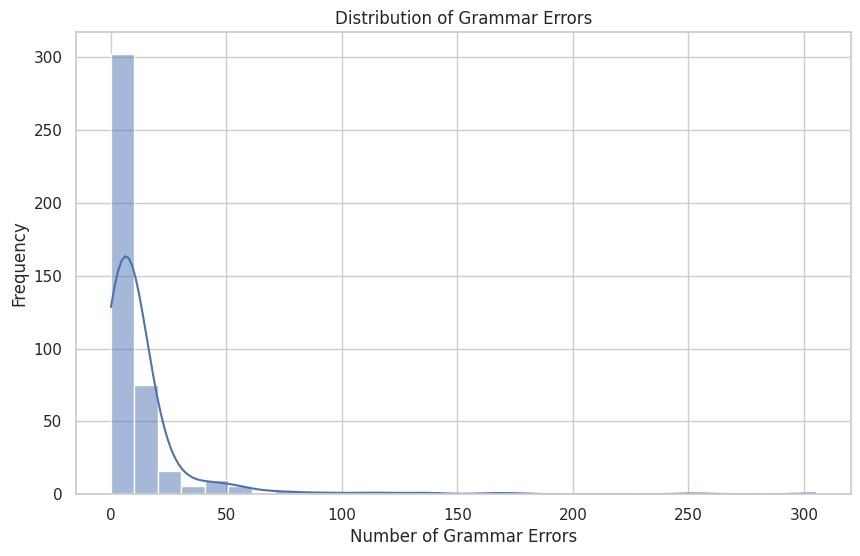

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


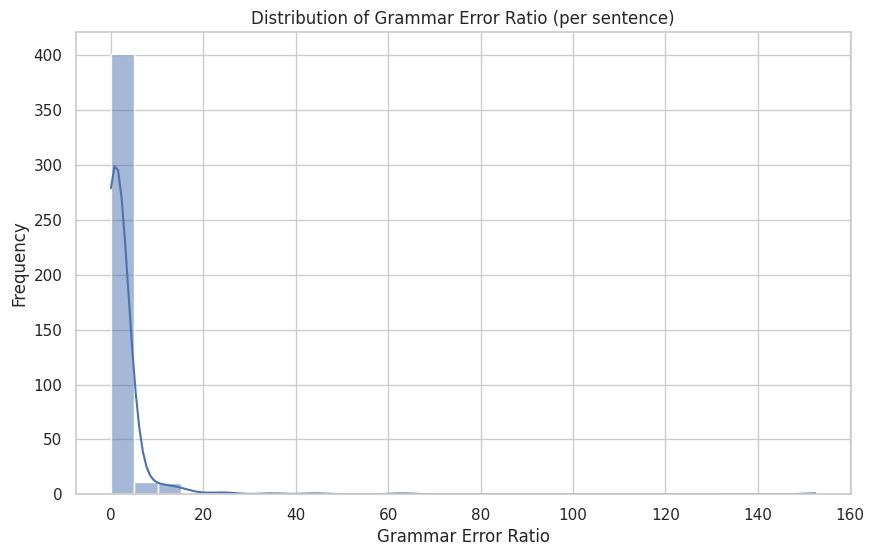

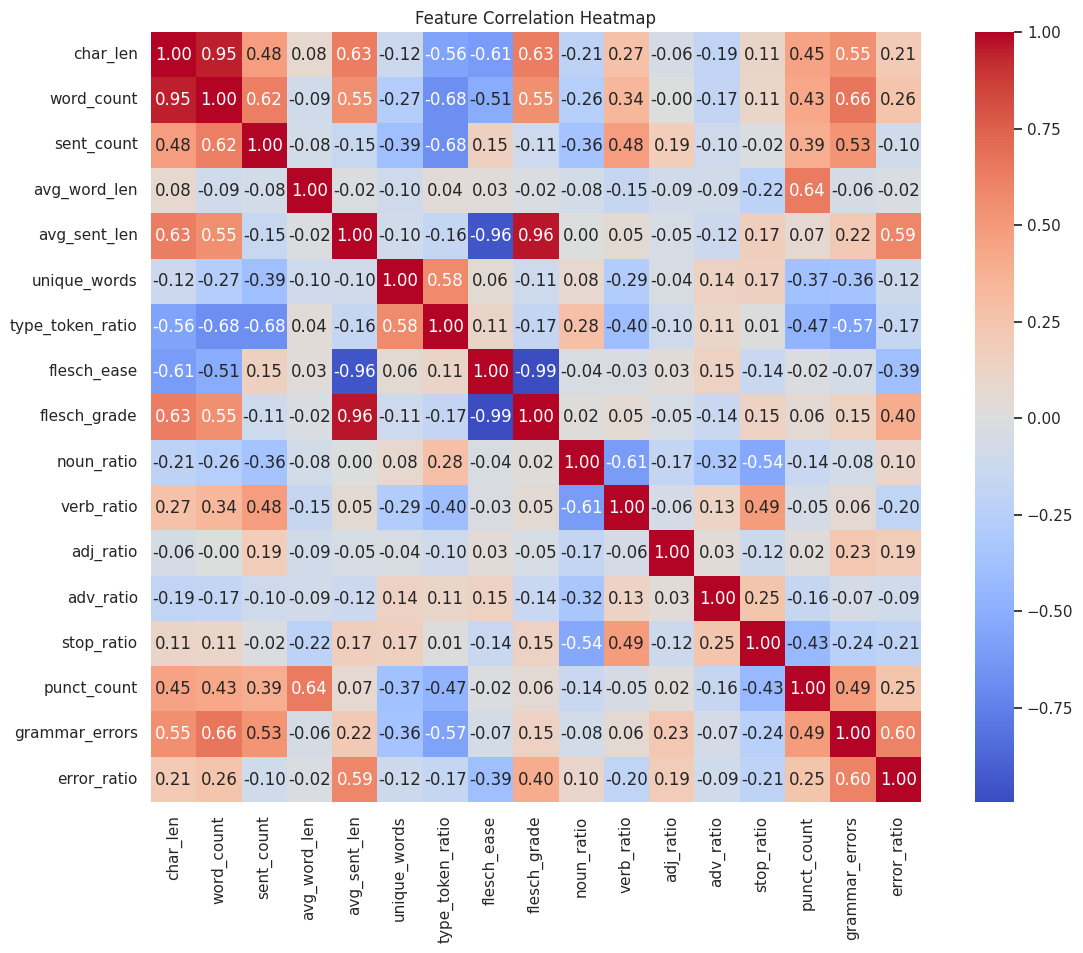

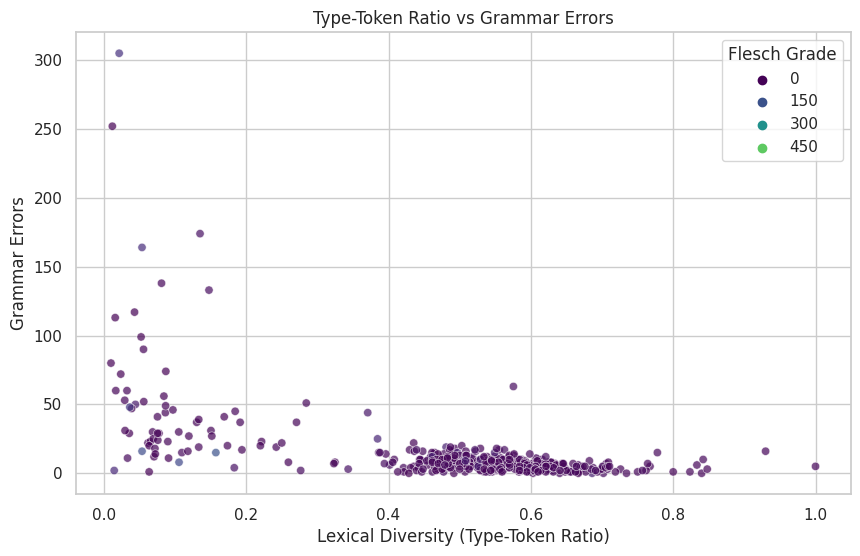

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ---------------------------
# 1. Distribution of Grammar Errors
# ---------------------------
sns.histplot(train_features['grammar_errors'], kde=True, bins=30)
plt.title("Distribution of Grammar Errors")
plt.xlabel("Number of Grammar Errors")
plt.ylabel("Frequency")
plt.show()

sns.histplot(train_features['error_ratio'], kde=True, bins=30)
plt.title("Distribution of Grammar Error Ratio (per sentence)")
plt.xlabel("Grammar Error Ratio")
plt.ylabel("Frequency")
plt.show()

# ---------------------------
# 2. Correlation Heatmap
# ---------------------------
numeric_cols = train_features.drop(columns=['file_name']).select_dtypes(include=np.number)
corr = numeric_cols.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# ---------------------------
# 4. Scatterplot: Type-Token Ratio vs Grammar Errors
# ---------------------------
sns.scatterplot(
    data=train_features,
    x='type_token_ratio',
    y='grammar_errors',
    hue='flesch_grade',
    palette='viridis',
    alpha=0.7
)
plt.title("Type-Token Ratio vs Grammar Errors")
plt.xlabel("Lexical Diversity (Type-Token Ratio)")
plt.ylabel("Grammar Errors")
plt.legend(title="Flesch Grade")
plt.show()


# Scaling features for mean = 0 and standard deviation = 1

In [26]:
from sklearn.preprocessing import StandardScaler

# --------------------------------------------
# 5. Normalize Features (excluding file_name)
# --------------------------------------------
scaler = StandardScaler()

# Select only the numeric feature columns
feature_cols = [col for col in train_features.columns if col != 'file_name']

# Fit on train, transform both train and test
train_scaled = scaler.fit_transform(train_features[feature_cols])
test_scaled  = scaler.transform(test_features[feature_cols])

# Replace the features in the original DataFrames (keeping file_name)
train_features_scaled = pd.DataFrame(train_scaled, columns=feature_cols)
train_features_scaled['file_name'] = train_features['file_name']
train_features_scaled = train_features_scaled[['file_name'] + feature_cols]

test_features_scaled = pd.DataFrame(test_scaled, columns=feature_cols)
test_features_scaled['file_name'] = test_features['file_name']
test_features_scaled = test_features_scaled[['file_name'] + feature_cols]

In [27]:
train_features_scaled


,file_name,char_len,word_count,sent_count,avg_word_len,avg_sent_len,unique_words,type_token_ratio,flesch_ease,flesch_grade,noun_ratio,verb_ratio,adj_ratio,adv_ratio,stop_ratio,punct_count,grammar_errors,error_ratio
0,audio_1002.wav,0.269492,-0.133972,-0.013510,0.051365,-0.194430,1.157069,0.670924,-0.020318,-0.122562,0.905811,-0.437503,-0.506249,-0.883700,-1.015363,-0.241343,-0.320002,-0.212075
1,audio_1005.wav,-0.461405,-0.369943,-0.346247,-0.070215,-0.144192,0.275590,0.597840,0.255120,-0.203144,-0.376920,0.317967,-0.941927,1.029433,-0.233461,-0.152499,-0.246649,-0.135705
2,audio_1007.wav,-0.450020,-0.432868,-0.429432,-0.042217,-0.120269,0.011146,0.536367,0.311673,-0.196945,-0.328062,-0.215965,-0.464022,0.959430,0.223170,-0.312419,-0.393356,-0.200620
3,audio_1012.wav,-0.538821,-0.598047,-0.346247,0.038447,-0.202005,-0.385519,0.758941,-0.006871,-0.134959,0.698245,0.031017,-0.922413,-0.103531,-0.944101,-0.294650,-0.430033,-0.231167
4,audio_1015.wav,-0.147187,0.235715,0.984701,-0.168747,-0.258912,-0.782185,-1.374351,0.558295,-0.379803,-1.378461,0.559929,1.549682,3.783616,0.734407,0.256185,0.340179,-0.149591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,audio_990.wav,-0.204111,-0.291286,-0.179879,-0.021490,-0.183066,0.584108,0.640982,0.174314,-0.187647,-0.364180,0.304315,-0.125385,0.131086,0.105805,-0.259112,-0.466709,-0.255033
427,audio_993.wav,5.060170,4.994453,5.975757,-0.136250,-0.244259,-0.649963,-2.234978,0.342891,-0.289924,-1.048660,2.862652,-1.396611,-1.333969,-0.046200,2.477292,2.797521,-0.143622
428,audio_994.wav,0.144261,-0.023853,-0.179879,-0.032480,-0.132231,0.848552,0.137799,0.228345,-0.178349,0.080507,-0.284644,-0.480452,0.128075,0.058724,-0.205805,-0.393356,-0.226394
429,audio_996.wav,0.410662,0.054804,-0.096694,0.005330,-0.144192,0.980773,0.069552,0.134090,-0.147357,0.124190,0.202896,-0.299581,-0.803986,0.496315,-0.205805,-0.393356,-0.231167


In [28]:
train_df = train_features_scaled.merge(
    train[['file_name', 'label']],
    on='file_name',
    how='left'
)

# Verify it worked
print(train_df[['file_name', 'label']].head())
test_df = test_features_scaled

        file_name  label
0  audio_1002.wav    5.0
1  audio_1005.wav    5.0
2  audio_1007.wav    4.5
3  audio_1012.wav    4.0
4  audio_1015.wav    5.0


# Replacing few null values with 0 

In [30]:
train_df['grammar_errors'] = train_df['grammar_errors'].fillna(0)
train_df['error_ratio'] = train_df['error_ratio'].fillna(0)


In [31]:
train_df.isna().sum()

file_name           0
char_len            0
word_count          0
sent_count          0
avg_word_len        0
avg_sent_len        0
unique_words        0
type_token_ratio    0
flesch_ease         0
flesch_grade        0
noun_ratio          0
verb_ratio          0
adj_ratio           0
adv_ratio           0
stop_ratio          0
punct_count         0
grammar_errors      0
error_ratio         0
label               0
dtype: int64

In [32]:
test_df['grammar_errors'] = test_df['grammar_errors'].fillna(0)
test_df['error_ratio'] = test_df['error_ratio'].fillna(0)


In [33]:
test_df.isna().sum()

file_name           0
char_len            0
word_count          0
sent_count          0
avg_word_len        0
avg_sent_len        0
unique_words        0
type_token_ratio    0
flesch_ease         0
flesch_grade        0
noun_ratio          0
verb_ratio          0
adj_ratio           0
adv_ratio           0
stop_ratio          0
punct_count         0
grammar_errors      0
error_ratio         0
dtype: int64

# Trying out ensemble models 

# Classic Bagging : Random Forest

In [42]:
# --------------------------------------------
# 1. Imports
# --------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --------------------------------------------
# 2. Prepare features & target
# --------------------------------------------
# Assuming `train_df` already exists in your session with all feature columns + 'label'
# Drop non‑feature columns
X = train_df.drop(columns=['file_name', 'label'])
y = train_df['label']

# --------------------------------------------
# 3. Train/Test split (80/20)
# --------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------------------------
# 4. Fit Random Forest
# --------------------------------------------
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,      
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)



RandomForestRegressor(n_jobs=-1, random_state=42)

In [43]:
# --------------------------------------------
# 5. Evaluate on validation set
# --------------------------------------------
y_pred = rf.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Validation MAE : {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")


Validation MAE : 0.7170
Validation RMSE: 0.8870


NOTE: these models score poor on the competition test set, as I am also not using 100 percent of the training data,I am first evaluating performance on a val set and tuning hyperparameters, after which I am training on complete training set and uploading for comp submission.
If i simply train on the whole train_set and tune model keeps overfitting.

In [44]:
# --------------------------------------------
# 5. Evaluate on training set
# --------------------------------------------
y_train_pred = rf.predict(X_train)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")


Train MAE: 0.2805
Train RMSE: 0.3497


In [ ]:
testset = test_df.drop(columns=["file_name"])

In [ ]:
predtest = rf.predict(testset)

In [ ]:
# Create the submission DataFrame
submission_df = pd.DataFrame({
    'filename': test_df['file_name'],
    'label': predtest
})

# Save it as a CSV
submission_df.to_csv('submission.csv', index=False)

# Classic Boosting : XBGRegressor

In [45]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,         # More trees, but we'll stop early
    learning_rate=0.05,       # Smaller steps = more generalization
    max_depth=4,              # Shallower trees generalize better
    subsample=0.8,            # Randomly sample 80% rows/tree
    colsample_bytree=0.8,     # Randomly sample 80% features/tree
    random_state=42,
    n_jobs=-1
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=30,   # Stop if no improvement
    verbose=False
)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [46]:
# --------------------------------------------
# 5. Evaluate on training set
# --------------------------------------------
y_train_pred = xgb.predict(X_train)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")


Train MAE: 0.4758
Train RMSE: 0.5783


In [47]:
# --------------------------------------------
# 5. Evaluate on validation set
# --------------------------------------------
y_pred = xgb.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Validation MAE : {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")


Validation MAE : 0.6901
Validation RMSE: 0.8555


In [ ]:
predtest1=xgb.predict(testset)
# Create the submission DataFrame
submission_df = pd.DataFrame({
    'filename': test_df['file_name'],
    'label': predtest1
})

# Save it as a CSV
submission_df.to_csv('submission1.csv', index=False)

Even after finetuning it is made clear that ensemble models dont perform too well, even tho train rmse(80 percent data) is around 0.5, we can definitely do better using transformers

In [60]:
# Add clean transcripts
train_df_new = train_df.copy()
test_df_new = test_df.copy()

train_df['transcript_clean'] = train_merged['transcript_clean']
test_df['transcript_clean'] = test_merged['transcript_clean']


In [59]:
#train_df.columns

Index(['file_name', 'char_len', 'word_count', 'sent_count', 'avg_word_len',
       'avg_sent_len', 'unique_words', 'type_token_ratio', 'flesch_ease',
       'flesch_grade', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio',
       'stop_ratio', 'punct_count', 'grammar_errors', 'error_ratio', 'label',
       'transcript'],
      dtype='object')

# Using bert-large and finetuning through LoRA(Low rank Adaptation)

In [61]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer
from peft import LoraConfig, get_peft_config, get_peft_model
import torch.nn as nn
import torch



# 0) (Assuming train_df and test_df are already loaded, and
#     train_df contains columns ["transcript_clean","label"],
#     test_df contains ["transcript_clean","file_name"] or similar.)

# 1) Dataset + DataLoader
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

class GrammarDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128, is_test=False):
        self.texts = df["transcript_clean"].tolist()
        self.labels = None if is_test else df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }
        if not self.is_test:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

batch_size = 16
train_ds = GrammarDataset(train_df, tokenizer, is_test=False)
test_ds  = GrammarDataset(test_df, tokenizer, is_test=True)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)


In [62]:
# 1) Load base model
base_model_name = "bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(base_model_name)
model = BertForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=1,           # single regression output
    problem_type="regression"
)

# 2) Create LoRA config
peft_config = LoraConfig(
  task_type="SEQ_CLS",     # sequence classification/regression
  inference_mode=False,
  r=4,                     # LoRA rank
  lora_alpha=16,
  lora_dropout=0.05,
  target_modules=["query", "value"]  # which attention projections to adapt
)

# 3) Wrap the model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()  # you’ll see only LoRA adapters + head are trainable


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 394,241 || all params: 335,537,154 || trainable%: 0.1175


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 1024, padding_idx=0)
          (position_embeddings): Embedding(512, 1024)
          (token_type_embeddings): Embedding(2, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-23): 24 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (

In [63]:
print(model.config.problem_type)

regression


In [64]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np

epochs = 15
optimizer = AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.SmoothL1Loss()

model.train()
for epoch in range(epochs):
    all_preds = []
    all_labels = []
    epoch_loss = 0.0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Get predictions (logits) and detach from GPU
        logits = outputs.logits.squeeze().detach().cpu().numpy()
        labels_np = labels.squeeze().detach().cpu().numpy()

        all_preds.extend(logits)
        all_labels.extend(labels_np)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    mse = mean_squared_error(all_labels, all_preds)
    rmse = np.sqrt(mse)
    pearson_corr, _ = pearsonr(all_labels, all_preds)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f} - MSE: {mse:.4f} - RMSE: {rmse:.4f} - Pearson: {pearson_corr:.4f}")


Epoch 1/15 - Loss: 86.5878 - MSE: 3.2082 - RMSE: 1.7911 - Pearson: 0.0202
Epoch 2/15 - Loss: 30.8640 - MSE: 1.1439 - RMSE: 1.0696 - Pearson: 0.0784
Epoch 3/15 - Loss: 28.9095 - MSE: 1.0707 - RMSE: 1.0348 - Pearson: 0.1768
Epoch 4/15 - Loss: 25.3168 - MSE: 0.9379 - RMSE: 0.9684 - Pearson: 0.3839
Epoch 5/15 - Loss: 19.7054 - MSE: 0.7302 - RMSE: 0.8545 - Pearson: 0.5820
Epoch 6/15 - Loss: 15.1616 - MSE: 0.5619 - RMSE: 0.7496 - Pearson: 0.6970
Epoch 7/15 - Loss: 13.7708 - MSE: 0.5099 - RMSE: 0.7141 - Pearson: 0.7327
Epoch 8/15 - Loss: 11.8849 - MSE: 0.4406 - RMSE: 0.6638 - Pearson: 0.7734
Epoch 9/15 - Loss: 10.7147 - MSE: 0.3967 - RMSE: 0.6298 - Pearson: 0.7982
Epoch 10/15 - Loss: 9.2455 - MSE: 0.3427 - RMSE: 0.5854 - Pearson: 0.8287
Epoch 11/15 - Loss: 8.6738 - MSE: 0.3212 - RMSE: 0.5667 - Pearson: 0.8414
Epoch 12/15 - Loss: 7.0936 - MSE: 0.2629 - RMSE: 0.5128 - Pearson: 0.8714
Epoch 13/15 - Loss: 7.0124 - MSE: 0.2600 - RMSE: 0.5099 - Pearson: 0.8729
Epoch 14/15 - Loss: 7.6307 - MSE: 0.28

In [65]:
# After training is complete
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
pearson_corr, _ = pearsonr(all_labels, all_preds)

print(f"Final Metrics after {epochs} epochs:")
print(f"MSE     : {mse:.4f}")
print(f"RMSE    : {rmse:.4f}")
print(f"Pearson : {pearson_corr:.4f}")


Final Metrics after 15 epochs:
MSE     : 0.1983
RMSE    : 0.4453
Pearson : 0.9048


In [66]:
model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze().cpu().numpy()  # .logits for regression, squeeze if needed
        all_preds.extend(preds)

# Convert predictions to float if needed
all_preds = [float(p) for p in all_preds]

submission = pd.DataFrame({
    "filename": test_df["file_name"],  # ID column in test_df
    "label":     all_preds
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")


Saved submission.csv


We observe that even for bert-large, when finetuned with PEFT, training RMSE is still around 0.4, but since it performs decently on the test set, pearson score of 0.749, we realize that its actually a good thing and that it is not overfitting.
We also observed that on increasing intrinsic rank: from 4 to 8 to 16, model starts overfitting, increasing the training RMSE but decreasing performance on test set.

When tuning with LoRA, especially without a validation set, it is extremely important to not overfit, as these transformers have millions of parameters and can fully learn the training set to get a 0.99 pearson, but that is not of use to us, we want our model to be able to generalize.